In [13]:
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ineqpy.inequality import atkinson,gini

In [4]:
def calculate_ratio(data,thres=20):
    upper_thres = np.percentile(data,100-thres)
    lower_thres = np.percentile(data,thres)
    
    upper_mean = np.mean(data[np.where(data>upper_thres)])
    lower_mean = np.mean(data[np.where(data>lower_thres)])
    
    return upper_mean/lower_mean

def calc_inequality_indices(results_dict):
    """
    Given a dictionary with the results, it calculates the different inequality indices
    of the incomes.
    """
    if "trip_avg_price" in results_dict:
        p = np.array(list(map(float,results_dict["trip_avg_price"])))
    elif "trip_income" in results_dict:
        p=np.array(list(map(float,results_dict["trip_income"])))
    else:
        return {
            "run_id" : results_dict["run_id"],
            "atkinson" : None,
            "gini" : None,
            "20/20_ratio" : None
        
        }
    
    return {
        "run_id" : results_dict["run_id"],
        "atkinson" : atkinson(p),
        "gini" : gini(p),
        "20/20_ratio" : calculate_ratio(p)
    }

In [5]:
def prepare_results(folder_nr: int, sim_nr: int):

    results_folders = [
        "test",
        
        "start_2020-1-6_end_2020-1-13_limit_25_taxis_10000",
        
        "start_2020-1-6_end_2020-1-13_limit_50_taxis_5000",
        "start_2020-1-6_end_2020-1-13_limit_50_taxis_10000",
        "start_2020-1-6_end_2020-1-13_limit_50_taxis_25000",
        
        "start_2020-1-6_end_2020-1-13_limit_50_taxis_20000",
        "start_2020-1-13_end_2020-1-20_limit_50_taxis_20000",
        "start_2020-1-20_end_2020-1-27_limit_50_taxis_20000",
        "start_2020-1-27_end_2020-2-3_limit_50_taxis_20000",
        
        "start_2020-1-6_end_2020-1-13_limit_35_taxis_10000",
        "start_2020-5-4_end_2020-5-11_limit_35_taxis_10000",
    ]

    simulations = [
        "run_test_config",
        
        "run_matching_nearest_initial_positions_home_behavior_stay",
        "run_matching_poorest_initial_positions_home_behavior_stay",
        "run_matching_random_limited_initial_positions_home_behavior_stay",
        
        # "run_matching_nearest_initial_positions_home_behavior_ml_dispatcher_prediction_areas_49",
        # "run_matching_poorest_initial_positions_home_behavior_ml_dispatcher_prediction_areas_49",
        # "run_matching_random_limited_initial_positions_home_behavior_ml_dispatcher_prediction_areas_49",
        
        "run_matching_nearest_initial_positions_home_behavior_ml_dispatcher_v2_prediction_areas_49",
        "run_matching_poorest_initial_positions_home_behavior_ml_dispatcher_v2_prediction_areas_49",
        "run_matching_random_limited_initial_positions_home_behavior_ml_dispatcher_v2_prediction_areas_49",
        
        "run_matching_nearest_initial_positions_home_behavior_ml_dispatcher_distributor_prediction_areas_49",
        "run_matching_poorest_initial_positions_home_behavior_ml_dispatcher_distributor_prediction_areas_49",
        "run_matching_random_limited_initial_positions_home_behavior_ml_dispatcher_distributor_prediction_areas_49",
        
        "run_matching_nearest_initial_positions_home_behavior_ml_dispatcher_v2_weighted_prediction_areas_49",
        "run_matching_poorest_initial_positions_home_behavior_ml_dispatcher_v2_weighted_prediction_areas_49",
        "run_matching_random_limited_initial_positions_home_behavior_ml_dispatcher_v2_weighted_prediction_areas_49",
    ]
    
    sim_name = simulations[sim_nr]
    folder_name = results_folders[folder_nr]

    aggr = f"../results/{folder_name}/{sim_name}_aggregates.csv.gz"
    per_req = f"../results/{folder_name}/{sim_name}_per_request_metrics.json.gz"
    per_taxi = f"../results/{folder_name}/{sim_name}_per_taxi_metrics.json.gz"
    
    with gzip.open(aggr) as f:
        df_aggr = pd.read_csv(f)
    
    with gzip.open(per_req) as f:
        per_req_dict = json.loads(f.read())
        per_req_df = pd.DataFrame.from_dict(per_req_dict['requests'])
        
    with gzip.open(per_taxi) as f:
        per_taxi_dict = json.loads(f.read())
        per_taxi_dict.pop("timestamp")
        per_taxi_df = pd.DataFrame.from_dict(per_taxi_dict)
    
    return sim_name, folder_name, df_aggr, per_req_df, per_taxi_df

In [6]:
def clean_sim_name(sim_name):
    matching = ""
    dispatching = ""
    
    sim_name = sim_name.split('_')
    for fluff in ['run', 'matching', 'initial', 'positions', 'home', 'behavior', 'prediction', 'areas', '49']:
        try:
            sim_name.remove(fluff)
        except:
            continue
    # sim_name = ", ".join(sim_name)
    
    ptr = 0
    print(sim_name)
    while ptr < len(sim_name):
        if sim_name[ptr] == "random":
            matching = "random limited"
            ptr += 1
        else:
            matching = sim_name[0]
        
        if sim_name[ptr] == "ml":
            if sim_name[ptr + 2] == "distributor":
                dispatching = "ml_neutral_weighted"
            elif sim_name[ptr + 2] == "v2" and ptr + 3 < len(sim_name) and sim_name[ptr + 3] == "weighted":
                dispatching = "ml_poorest_weighted"
            else:
                dispatching = "ml_poorest"
            break
        
        if sim_name[ptr] == "stay":
            dispatching = "stay"
        
        ptr += 1
        
    return matching, dispatching

In [7]:
def prepare_result_dataframe():
    cols = ['start', 'end', 'taxis', 'radius', 'matching', 'dispatching', 'gini', 'atkinson', '20/20', 'total_utility', 'missed_requests', 'missed_requests_perc', 'idle_drivers', 'idle_drivers_perc']
    results_df = pd.DataFrame(columns=cols)
    # folder = 4
    
    for folder in range(1, 11):
        for sim in range(1, 13):
            try:
                sim_name, folder_name, df_aggr, per_req_df, per_taxi_df = prepare_results(folder, sim)
            except FileNotFoundError:
                print(f"Simulation {sim} not found in folder {folder}, skipped.")
                continue
            
            missed_requests = per_req_df['pickup'].isna().sum()
            idle_drivers = per_taxi_df[per_taxi_df['trip_num_completed'] == 0].shape[0]
            
            gini_score = gini(per_taxi_df['trip_income'].values)
            atkinson_score = atkinson(per_taxi_df['trip_income'].values)
            twenty_twenty_ratio = calculate_ratio(per_taxi_df['trip_income'].values)
            
            folder_lst = folder_name.split('_')
            folder_lst = [el for el in folder_lst if el not in ['start', 'end', 'limit', 'taxis']]
            
            matching, dispatching = clean_sim_name(sim_name)
            
            new_row = pd.DataFrame({
                'start': folder_lst[0],
                'end': folder_lst[1],
                'taxis': folder_lst[3],
                'radius': folder_lst[2],
                'matching': matching, 
                'dispatching': dispatching,
                'gini': gini_score, 
                'atkinson': atkinson_score, 
                '20/20': twenty_twenty_ratio, 
                'total_utility': per_taxi_df['trip_income'].sum(), 
                'missed_requests': missed_requests, 
                'missed_requests_perc': round(missed_requests / per_req_df.shape[0] * 100, 2), 
                'idle_drivers': idle_drivers, 
                'idle_drivers_perc': round(idle_drivers / per_taxi_df.shape[0] * 100, 2)
            }, index=[0])
            
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

# Inequality

In [8]:
results_df = prepare_result_dataframe()

['nearest', 'stay']
['poorest', 'stay']
['random', 'limited', 'stay']
Simulation 4 not found in folder 1, skipped.
Simulation 5 not found in folder 1, skipped.
Simulation 6 not found in folder 1, skipped.
Simulation 7 not found in folder 1, skipped.
Simulation 8 not found in folder 1, skipped.
Simulation 9 not found in folder 1, skipped.
Simulation 10 not found in folder 1, skipped.
Simulation 11 not found in folder 1, skipped.
Simulation 12 not found in folder 1, skipped.
['nearest', 'stay']
['poorest', 'stay']
['random', 'limited', 'stay']
Simulation 4 not found in folder 2, skipped.
Simulation 5 not found in folder 2, skipped.
Simulation 6 not found in folder 2, skipped.
Simulation 7 not found in folder 2, skipped.
Simulation 8 not found in folder 2, skipped.
Simulation 9 not found in folder 2, skipped.
Simulation 10 not found in folder 2, skipped.
Simulation 11 not found in folder 2, skipped.
Simulation 12 not found in folder 2, skipped.
['nearest', 'stay']
['poorest', 'stay']
['ra

In [9]:
# results_df = results_df.sort_values('sim_name').reset_index(drop=True).sort_values('gini')
results_df = results_df.convert_dtypes().round(3)
results_df

,start,end,taxis,radius,matching,dispatching,gini,atkinson,20/20,total_utility,missed_requests,missed_requests_perc,idle_drivers,idle_drivers_perc
0,2020-1-6,2020-1-13,10000,25,nearest,stay,0.342,0.096,1.688,6334608.608,996,1.01,26,0.26
1,2020-1-6,2020-1-13,10000,25,poorest,stay,0.091,0.008,1.272,6327086.664,963,0.98,0,0.0
2,2020-1-6,2020-1-13,10000,25,random,stay,0.288,0.067,1.587,6324419.0,997,1.01,7,0.07
3,2020-1-6,2020-1-13,5000,50,nearest,stay,0.287,0.07,1.534,6344366.576,860,0.87,1,0.02
4,2020-1-6,2020-1-13,5000,50,poorest,stay,0.051,0.003,1.157,6347238.32,792,0.81,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2020-5-4,2020-5-11,10000,35,poorest,ml_neutral_weighted,0.818,0.198,1.468,245392.576,7,0.2,6667,66.67
66,2020-5-4,2020-5-11,10000,35,random,ml_neutral_weighted,0.84,0.193,1.355,245181.696,7,0.2,6992,69.92
67,2020-5-4,2020-5-11,10000,35,nearest,ml_poorest_weighted,0.843,0.206,1.376,249341.12,0,0.0,7021,70.21
68,2020-5-4,2020-5-11,10000,35,poorest,ml_poorest_weighted,0.816,0.193,1.463,248365.488,3,0.09,6678,66.78


In [10]:
results_df_grouped = results_df.sort_values(['taxis', 'radius', 'start', 'end', 'gini'])
results_df_grouped.to_csv('../results/final_results.csv')

In [11]:

# out_1 = results_df[
#     (results_df['taxis'] == '25000') & 
#     (results_df['radius'] == '50') &
#     # (results_df['start'] == '2020-1-6') &
#     # (results_df['matching'] == 'poorest') &
#     ((results_df['dispatching'] == 'ml_poorest_weighted') |
#     (results_df['dispatching'] == 'stay'))
#     ]\
out_1 = results_df.sort_values(['start', 'gini'])\
    .iloc[:, [0,4,5,6,7,8,9,11,13]]\
    .rename({'missed_requests_perc': 'missed req %',
             'idle_drivers_perc': 'idle drivers %',
             'total_utility': 'total income $1M'}, axis=1)

out_1.loc[:, "total income $1M"] = (out_1.loc[:, "total income $1M"]/1000000).round(3)
out_1.to_latex('all_results.tex', index=False)
# out_1[out_1['dispatching'] == 'ml_poorest_weighted'].describe()
out_1


/tmp/ipykernel_821372/1214943151.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  out_1.to_latex('all_results.tex', index=False)


,start,matching,dispatching,gini,atkinson,20/20,total income $1M,missed req %,idle drivers %
40,2020-1-13,poorest,ml_poorest_weighted,0.132,0.017,1.376,6.992,0.23,0.0
37,2020-1-13,poorest,stay,0.142,0.02,1.44,7.004,0.36,0.0
38,2020-1-13,random,stay,0.371,0.111,1.789,7.007,0.33,1.03
41,2020-1-13,random,ml_poorest_weighted,0.391,0.123,1.81,7.014,0.24,1.08
36,2020-1-13,nearest,stay,0.397,0.125,1.853,7.044,0.13,1.2
...,...,...,...,...,...,...,...,...,...
63,2020-5-4,nearest,ml_poorest,0.843,0.205,1.364,0.249,0.0,70.14
67,2020-5-4,nearest,ml_poorest_weighted,0.843,0.206,1.376,0.249,0.0,70.21
60,2020-5-4,nearest,stay,0.844,0.203,1.372,0.25,0.0,70.68
62,2020-5-4,random,stay,0.848,0.199,1.342,0.249,0.23,71.35


### Grouped bar charts

ValueError: shape mismatch: objects cannot be broadcast to a single shape

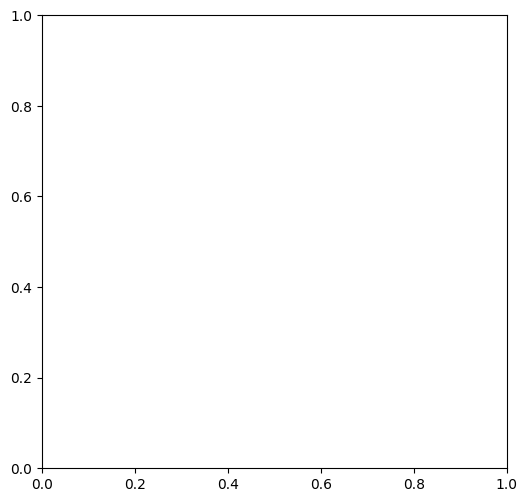

In [22]:

out = out_1
# out.loc[:, "total_utility"] = (out.loc[:, "total_utility"]/1000000).round(3)


label_a = 'ml_poorest_weighted'
label_b = 'stay'

a = out[out['dispatching'] == label_a].loc[:, 'gini'].values
b = out[out['dispatching'] == label_b].loc[:, 'gini'].values

# a = out[out['dispatching'] == label_a].loc[:, 'total_utility']
# b = out[out['dispatching'] == label_b].loc[:, 'total_utility']

group_labels = out.loc[:, 'matching'].unique()
x = np.arange(len(group_labels))

fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot()

width = 0.4  # the width of the bars
rects1 = ax.bar(x - width/2, a, width, label=label_a, color="#1e3d59")
rects2 = ax.bar(x + width/2, b, width, label=label_b, color="#ff6e40")

# rects1 = ax.bar(x - width/2, a, width, label=label_a, color="#1868ae")
# rects2 = ax.bar(x + width/2, b, width, label=label_b, color="#c6d7eb")

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Total income in millions USD')
# ax.set_title('Total income by simulation week, poorest matching')
ax.set_ylabel('Gini')
ax.set_title('Gini scores by matching algorithm, in one week')

ax.set_xticks(x, group_labels)
ax.set_ymargin(0.18)
ax.legend(loc='upper left', facecolor="white")

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

# plt.savefig('/home/chris/Documents/UNI/HS21/bachelor_thesis/figures/gbar_gini_poorest_weight_all_matchings_one_week_25k.png', dpi=600)
plt.show()

## Incomes for each simulation in a folder

In [15]:
# Generate dataframe with incomes for each simulation in folder "folder"

folders = [3, 4, 5]
sims_incomes = {}

for folder in folders:
    sims_incomes[folder] = {}
    
    for sim in range(1, 13):
        try:
            sim_name, folder_name, df_aggr, per_req_df, per_taxi_df = prepare_results(folder, sim)
        except FileNotFoundError:
            print(f"Simulation {sim} not found in folder {folder}, skipped.")
            continue
        
        folder_lst = folder_name.split('_')
        folder_lst = [el for el in folder_lst if el not in ['start', 'end', 'limit', 'taxis']]
        
        sim_name_clean = ", ".join(clean_sim_name(sim_name))
        sims_incomes[folder][sim_name_clean] = per_taxi_df.loc[:, 'trip_income']
        sims_incomes[folder]['num_taxis'] = folder_lst[3]
    
# sims_incomes = pd.concat([pd.DataFrame(sims_incomes[3]), pd.DataFrame(sims_incomes[5])])
# sims_incomes = pd.DataFrame(sims_incomes[5])
sims_incomes

['nearest', 'stay']
['poorest', 'stay']
['random', 'limited', 'stay']
['nearest', 'ml', 'dispatcher', 'v2']
['poorest', 'ml', 'dispatcher', 'v2']
['random', 'limited', 'ml', 'dispatcher', 'v2']
['nearest', 'ml', 'dispatcher', 'distributor']
['poorest', 'ml', 'dispatcher', 'distributor']
['random', 'limited', 'ml', 'dispatcher', 'distributor']
['nearest', 'ml', 'dispatcher', 'v2', 'weighted']
['poorest', 'ml', 'dispatcher', 'v2', 'weighted']
['random', 'limited', 'ml', 'dispatcher', 'v2', 'weighted']
['nearest', 'stay']
['poorest', 'stay']
['random', 'limited', 'stay']
Simulation 4 not found in folder 4, skipped.
Simulation 5 not found in folder 4, skipped.
Simulation 6 not found in folder 4, skipped.
Simulation 7 not found in folder 4, skipped.
Simulation 8 not found in folder 4, skipped.
Simulation 9 not found in folder 4, skipped.
['nearest', 'ml', 'dispatcher', 'v2', 'weighted']
['poorest', 'ml', 'dispatcher', 'v2', 'weighted']
['random', 'limited', 'ml', 'dispatcher', 'v2', 'weight

{3: {'nearest, stay': 0       1145.200
  1        428.592
  2        595.176
  3        855.160
  4        714.240
            ...   
  9995     543.632
  9996     889.888
  9997     862.120
  9998     380.928
  9999     684.576
  Name: trip_income, Length: 10000, dtype: float64,
  'num_taxis': '10000',
  'poorest, stay': 0       552.784
  1       665.192
  2       654.152
  3       597.040
  4       680.888
           ...   
  9995    564.488
  9996    568.904
  9997    587.792
  9998    629.624
  9999    588.928
  Name: trip_income, Length: 10000, dtype: float64,
  'random, stay': 0       353.256
  1       411.504
  2       834.984
  3       316.600
  4       521.912
           ...   
  9995    468.456
  9996    256.536
  9997    786.712
  9998      1.992
  9999    258.216
  Name: trip_income, Length: 10000, dtype: float64,
  'nearest, ml_poorest': 0       1771.664
  1         31.120
  2       2197.552
  3       1416.056
  4       1610.944
            ...   
  9995      18.496
  9996

In [17]:
sims_incomes_3 = pd.DataFrame(sims_incomes[3])
sims_incomes_4 = pd.DataFrame(sims_incomes[4])
sims_incomes_5 = pd.DataFrame(sims_incomes[5])
# sims_incomes_3['nearest, ml_neutral_weighted'].max()

sims_incomes_4

,"nearest, stay",num_taxis,"poorest, stay","random, stay","nearest, ml_poorest_weighted","poorest, ml_poorest_weighted","random, ml_poorest_weighted"
0,252.992,25000,228.648,523.120,124.424,196.648,57.432
1,0.000,25000,200.200,701.552,363.128,192.496,415.368
2,206.344,25000,205.360,562.384,64.744,289.096,459.392
3,333.336,25000,191.568,178.544,0.768,186.000,196.896
4,57.552,25000,218.688,350.880,952.424,205.440,413.512
...,...,...,...,...,...,...,...
24995,288.712,25000,419.584,140.528,7.776,235.160,274.960
24996,335.296,25000,284.816,421.672,1.520,253.400,139.120
24997,641.880,25000,195.784,135.800,88.920,203.648,63.368
24998,18.864,25000,213.312,79.568,21.952,194.768,254.864


### Make visualization for income distributions

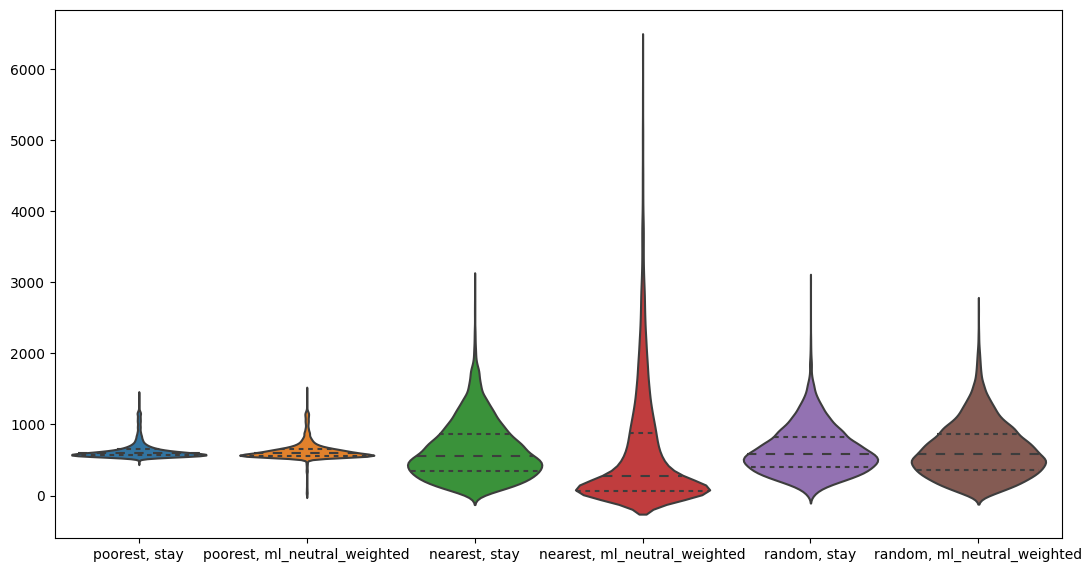

In [50]:
import joypy
import seaborn as sns

cols_order = [
    'poorest, stay',
    'poorest, ml_neutral_weighted', 
    # 'poorest, ml_poorest',
    # 'poorest, ml_poorest_weighted', 
    'nearest, stay', 
    'nearest, ml_neutral_weighted', 
    # 'nearest, ml_poorest',
    # 'nearest, ml_poorest_weighted', 
    'random, stay',
    'random, ml_neutral_weighted', 
    # 'random, ml_poorest',
    # 'random, ml_poorest_weighted', 
    ]

# cols_order = [
#     'poorest, stay',
#     'nearest, stay', 
#     'random, stay',
#     'poorest, ml_neutral_weighted', 
#     'nearest, ml_neutral_weighted', 
#     'random, ml_neutral_weighted', 
#     'poorest, ml_poorest',
#     'nearest, ml_poorest',
#     'random, ml_poorest',
#     'poorest, ml_poorest_weighted', 
#     'nearest, ml_poorest_weighted', 
#     'random, ml_poorest_weighted', 
#     ]

df = sims_incomes_3.reindex(cols_order, axis=1)

# Draw Plot
# plt.figure(figsize=(6, 6), dpi=100)
# fig, axes = joypy.joyplot(df, figsize=(8, 7), overlap=2, range_style='own', fade=True, color="steelblue", linecolor='black', grid=True)

plt.figure(figsize=(13,7), dpi= 100)
sns.violinplot(data=df, scale='width', inner='quartile')

# Decoration
plt.savefig('/home/chris/Documents/UNI/HS21/bachelor_thesis/figures/violin_neutral_weighted_10k_50.png', dpi=600)
# plt.title('Ridge Plot of Income Distributions with ', fontsize=22)
plt.show()

In [100]:
# sim_name, folder_name, df_aggr, per_req_df, per_taxi_df = prepare_results(5, 8)
sim_name, folder_name, df_aggr, per_req_df, per_taxi_df = prepare_results(3, 8)

df_aggr

,Unnamed: 0,timestamp,avg_timestamp,std_timestamp,avg_trip_income,std_trip_income,avg_time_serving,std_time_serving,avg_time_cruising,std_time_cruising,avg_time_waiting,std_time_waiting,avg_time_to_request,std_time_to_request
0,0,15120,15120.0,0.0,633.9909,134.4047,628.5084,135.0647,751.2391,271.6859,13360.0809,423.2091,380.4694,185.3584


In [274]:
# per_taxi_df
np.average(per_taxi_df['trip_num_completed'])

4.89065

In [102]:
per_req_df

,request_id,origin,destination,timestamp,assignment,pickup,dropoff
0,0,"[155, 132]","[157, 158]",0,1.0,40.0,68.0
1,1,"[201, 412]","[205, 382]",0,1.0,339.0,373.0
2,2,"[242, 260]","[198, 244]",0,1.0,25.0,85.0
3,3,"[232, 276]","[241, 62]",0,1.0,46.0,269.0
4,4,"[96, 305]","[163, 364]",1,2.0,31.0,157.0
...,...,...,...,...,...,...,...
98305,98305,"[224, 241]","[219, 228]",15118,15119.0,NaN,NaN
98306,98306,"[233, 268]","[243, 275]",15118,15119.0,NaN,NaN
98307,98307,"[207, 248]","[207, 248]",15118,15119.0,NaN,NaN
98308,98308,"[213, 350]","[213, 350]",15118,15119.0,NaN,NaN


In [105]:
# Computing demand to supply ratio R
R = ((per_req_df.shape[0] / df_aggr['timestamp']) * np.average(per_taxi_df['trip_avg_length'])) / (per_taxi_df.shape[0] * 10)
R

0    0.04714
Name: timestamp, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


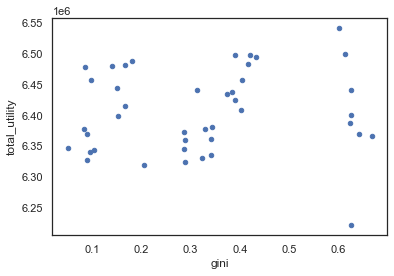

In [256]:
scatter_df = results_df[results_df['start'] == "2020-1-6"]
ax = scatter_df.plot.scatter(x='gini', 
                             y='total_utility')